In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from datasetsforecast.losses import mae, mape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Preprocess Data

In [2]:
# Load data
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

# Data Preprocessing
df = df.drop(columns=['Operating Airline IATA Code', 'Published Airline IATA Code', 'data_as_of', 'data_loaded_at']).reset_index(drop=True)
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df = df.groupby(by=['Activity Period Start Date']).agg({'Passenger Count': 'sum'}).reset_index()
df = df.rename(columns={
    "Activity Period Start Date": "date",
    "Passenger Count": "passenger_count"
})

# Split data Pre and Post Covid 19 Pandemic
1. The reason we split it because due to behavior of the passengers are different between pre and post Covid 19 Pandemic. 
2. From previous EDA, the trend of the data and the pattern of seasonality for both are different. 

In [3]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<='2019-01-01']
test_pre_covid = df_pre_covid[df_pre_covid['date']>'2019-01-01']
train_post_covid = df_post_covid[df_post_covid['date']<='2022-12-01']
test_post_covid = df_post_covid[df_post_covid['date']>'2022-12-01']

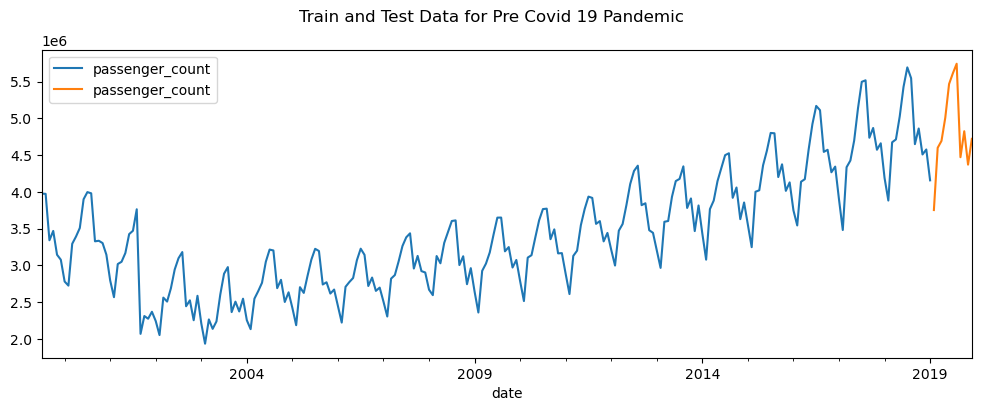

In [4]:
# Visualize Train and Testing Data for Pre Covid 19 Pandemic
fig, ax = plt.subplots(figsize=(12, 4))
train_pre_covid.set_index('date').plot(ax=ax, label='train')
test_pre_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Pre Covid 19 Pandemic")
plt.show()

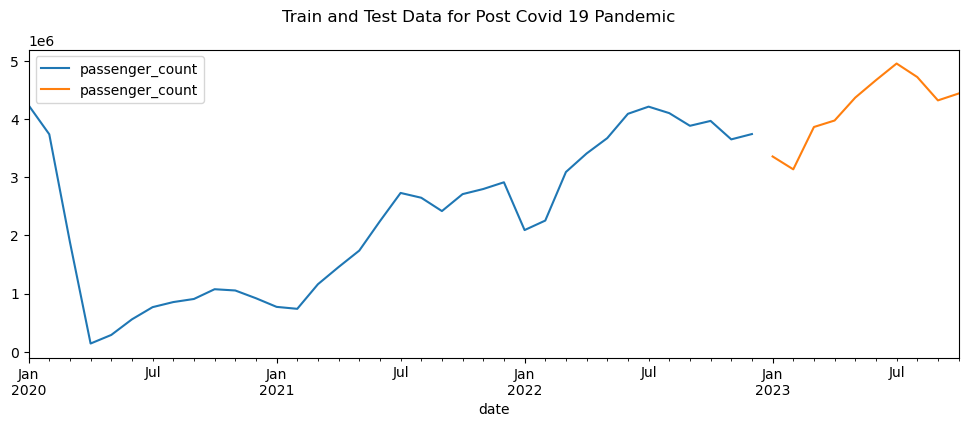

In [5]:
# Visualize Train and Testing Data for Post Covid 19 Pandemic
fig, ax = plt.subplots(figsize=(12, 4))
train_post_covid.set_index('date').plot(ax=ax, label='train')
test_post_covid.set_index('date').plot(ax=ax, label='test')
fig.suptitle("Train and Test Data for Post Covid 19 Pandemic")
plt.show()

# Check Stationarity of Our Dataset

In [20]:
adftest = adfuller(train_pre_covid['passenger_count'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.7773675461465617
P-Value: 0.017741844607067448
Number of lags: 13
Number of observations: 221
Critical Values: {'1%': -4.000328734182328, '5%': -3.430545275531156, '10%': -3.1388319837220435}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [21]:
adftest = adfuller(train_post_covid['passenger_count'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.6649103927926876
P-Value: 0.2509388993166092
Number of lags: 5
Number of observations: 30
Critical Values: {'1%': -4.2970953703703705, '5%': -3.5685571851851847, '10%': -3.2184266666666668}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


# Check Seasonality

## Seasonality Plot

In [6]:
def yearly_seasonality_plot(data, date_column, target, title):
    data = data
    data.loc[:, 'month'] = data[date_column].dt.month
    data.loc[:, 'year'] = data[date_column].dt.year
    ax = sns.lineplot(
        data=data,
        x='month',
        y=target,
        hue='year',
    )
    ax.set(
        title=title,
        xlabel='month',
        ylabel=target
    )
    plt.show()

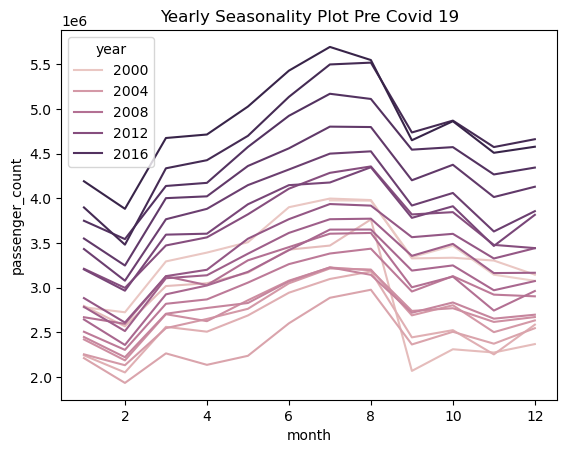

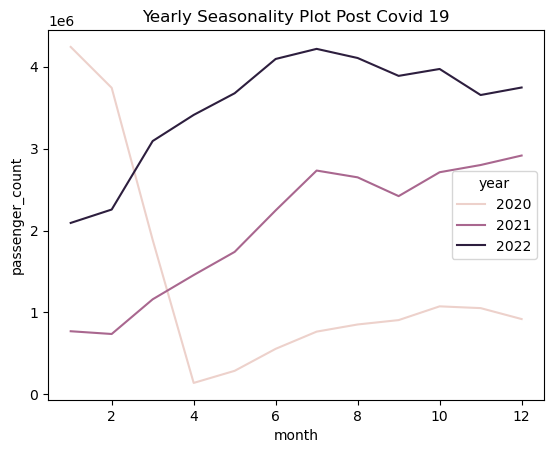

In [8]:
yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Pre Covid 19')
yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Post Covid 19')

## Sub Series Seasonality Plots

In [11]:
def subseries_yearly_seasonality_plot(data, date_column, target, title):
    data = data
    data.loc[:, 'month'] = data[date_column].dt.month
    data.loc[:, 'year'] = data[date_column].dt.year
    mean_by_month = data.groupby(by='month').agg({'passenger_count': 'mean'})
    data = data.merge(mean_by_month, on='month', how='left')
    fg = sns.relplot(
        data=data,
        x='year',
        y='passenger_count_x',
        col='month',
        kind='line'
    )

    for i, ax in enumerate(fg.axes.flat):
        sns.lineplot(data=data[data['month']==i+1], x='year', y='passenger_count_y', color='orange', ax=ax)
    
    fg.figure.suptitle(title)
    plt.show()

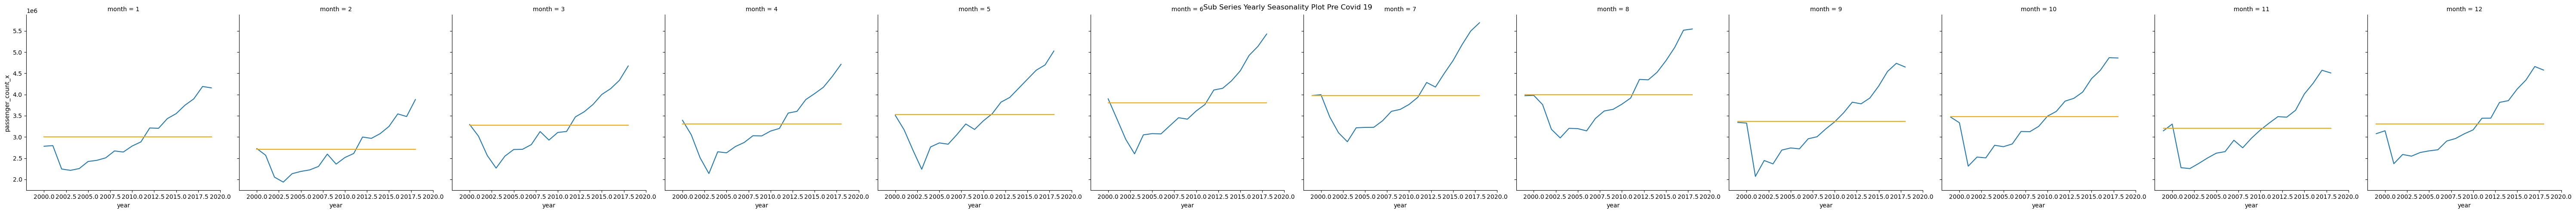

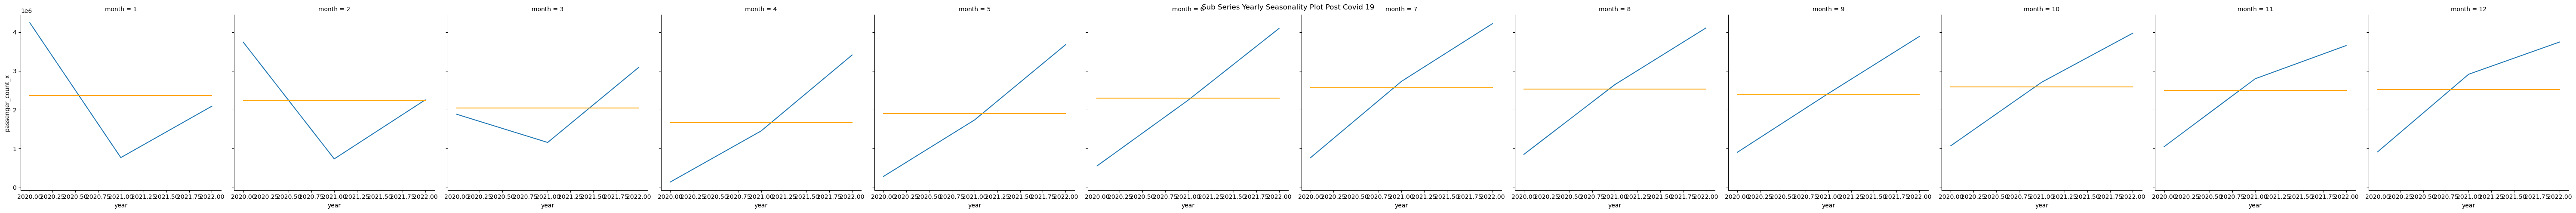

In [12]:
subseries_yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Pre Covid 19')
subseries_yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Post Covid 19')

Explanation:
1. From the Pre Covid 19 Pandemic, there's a positive trend overtime and patten exists where the peck of the passenger count occurs in `August`.
2. From the Post Covid 19 Pandemic, there's a positive trend overtime (due to recovery from the pandemic), but there's no significant pattern.

## Autocorrelation and Partial Autocorrelation Plot

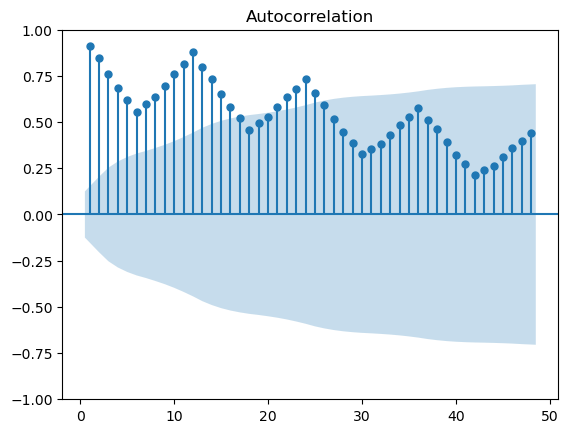

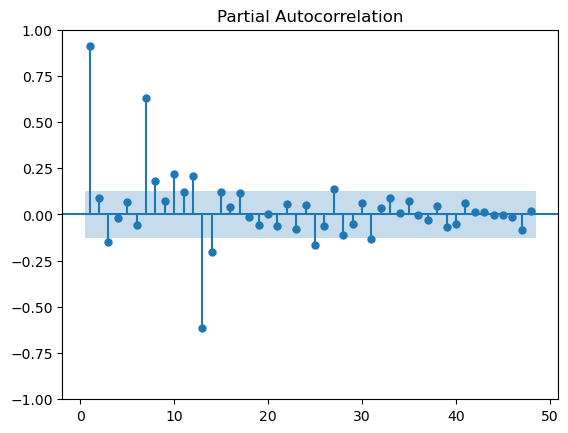

In [18]:
plot_acf(df_pre_covid['passenger_count'], zero=False, lags=48)
plot_pacf(df_pre_covid['passenger_count'], zero=False, lags=48)
plt.show()

Explanation:
1. ACF plot confirms the yearly seasonality because of the string correlation for at 12 lag interval

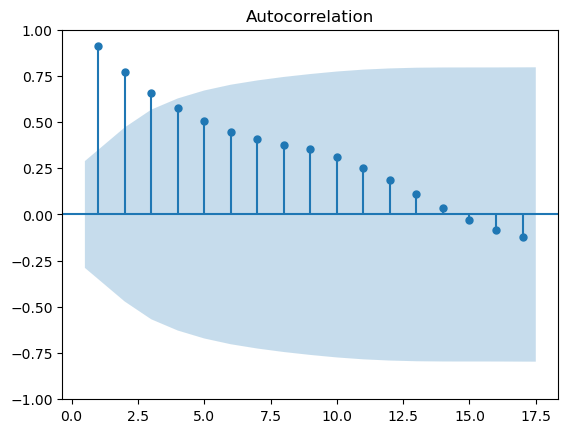

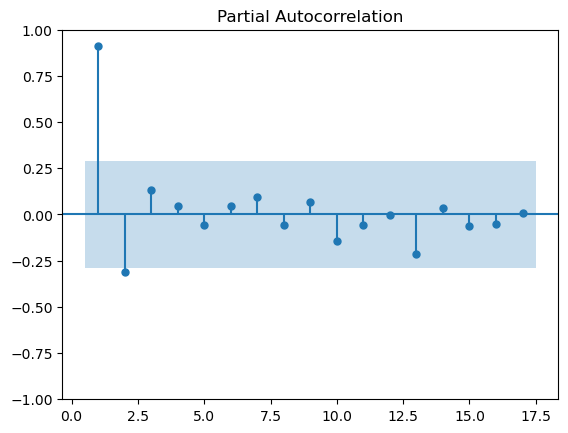

In [17]:
plot_acf(df_post_covid['passenger_count'], zero=False)
plot_pacf(df_post_covid['passenger_count'], zero=False)
plt.show()

Explanation:
1. Changing in behavior after the Covid 19 Pandemic which we can see that there's a `Tails-Off` at Autocorrelation Plot and `Cuts-Off` at Partial Autocorrelation plot. Suggesting a MA model

# Data Preparation for Modelling

In [6]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_pre_covid['unique_id'] = 1
df_post_covid = df[df['date']>='2020-04-01']
df_post_covid['unique_id'] = 1

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<'2019-01-01'].reset_index(drop=True)
test_pre_covid = df_pre_covid[df_pre_covid['date']>='2019-01-01'].reset_index(drop=True)
train_post_covid = df_post_covid[df_post_covid['date']<'2023-01-01'].reset_index(drop=True)
test_post_covid = df_post_covid[df_post_covid['date']>='2023-01-01'].reset_index(drop=True)
train_pre_covid = train_pre_covid.rename(columns={'date': 'ds', 'passenger_count': 'y'})
test_pre_covid = test_pre_covid.rename(columns={'date': 'ds', 'passenger_count': 'y_test'})
train_post_covid = train_post_covid.rename(columns={'date': 'ds', 'passenger_count': 'y'})
test_post_covid = test_post_covid.rename(columns={'date': 'ds', 'passenger_count': 'y_test'})

C:\Users\USER\AppData\Local\Temp\ipykernel_28736\2026109843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre_covid['unique_id'] = 1
C:\Users\USER\AppData\Local\Temp\ipykernel_28736\2026109843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post_covid['unique_id'] = 1


# StatsForecast

# Model

## Pre Covid

In [7]:
from statsforecast.models import HistoricAverage, SeasonalNaive, AutoARIMA, AutoETS

models = [
    HistoricAverage(),
    SeasonalNaive(season_length=12),
    AutoARIMA(season_length=12),
    AutoETS(season_length=12)
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_pre_covid
)

# Perform Cross Validation
start = time.time()
crossvalidation_df = sf.cross_validation(
    df = train_pre_covid,
    h = 12,
    step_size = 12,
    n_windows = 3
).reset_index()
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Finished Cross Validation, took about 41.34 seconds


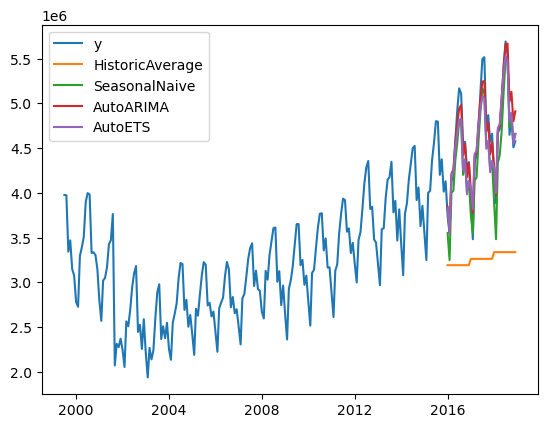

In [8]:
plt.plot(train_pre_covid['ds'], train_pre_covid['y'], label='y')
for model in models:
    plt.plot(crossvalidation_df['ds'], crossvalidation_df[model.__class__.__name__], label=model.__class__.__name__)
plt.legend()
plt.show()

In [9]:
uids = test_pre_covid.unique_id.unique()
unique_ids = []
methods = []
maes = []
mapes = []
for method in models:
    for uid in uids:
        filtered_forecast = crossvalidation_df[crossvalidation_df['unique_id']==uid]
        
        unique_ids.append(uid)
        methods.append(method.__class__.__name__)
        maes.append(mae(filtered_forecast['y'], filtered_forecast[method.__class__.__name__]))
        mapes.append(mape(filtered_forecast['y'], filtered_forecast[method.__class__.__name__]))

crossvalidation_eval_df = pd.DataFrame({
    'unique_id': unique_ids,
    'method': methods,
    'mae': maes,
    'mape': mapes
})

crossvalidation_eval_df

,unique_id,method,mae,mape
0,1,HistoricAverage,1.366785e+06,28.544489
1,1,SeasonalNaive,2.304819e+05,4.999797
2,1,AutoARIMA,1.227226e+05,2.672295
3,1,AutoETS,1.680970e+05,3.600029


## Post Covid

In [53]:
from statsforecast.models import HistoricAverage, SeasonalNaive, AutoARIMA, AutoETS

models = [
    HistoricAverage(),
    SeasonalNaive(season_length=1),
    AutoARIMA(season_length=1),
    AutoETS(season_length=1),
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_post_covid
)

# Perform Cross Validation
start = time.time()
crossvalidation_df = sf.cross_validation(
    df = train_post_covid,
    h = 12,
    step_size = 12,
    n_windows = 1
).reset_index()
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Finished Cross Validation, took about 0.27 seconds


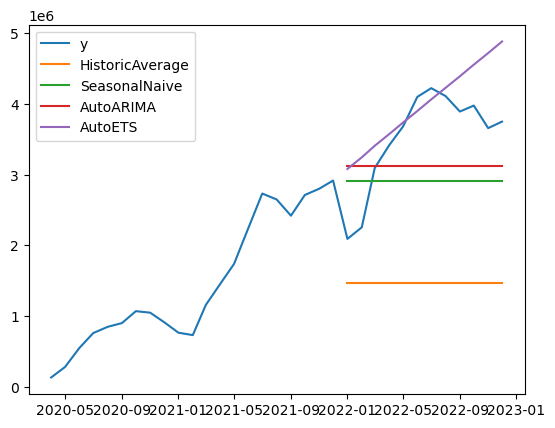

In [54]:
plt.plot(train_post_covid['ds'], train_post_covid['y'], label='y')
for model in models:
    plt.plot(crossvalidation_df['ds'], crossvalidation_df[model.__class__.__name__], label=model.__class__.__name__)
plt.legend()
plt.show()

In [55]:
uids = test_post_covid.unique_id.unique()
unique_ids = []
methods = []
maes = []
mapes = []
for method in models:
    for uid in uids:
        filtered_forecast = crossvalidation_df[crossvalidation_df['unique_id']==uid]
        
        unique_ids.append(uid)
        methods.append(method.__class__.__name__)
        maes.append(mae(filtered_forecast['y'], filtered_forecast[method.__class__.__name__]))
        mapes.append(mape(filtered_forecast['y'], filtered_forecast[method.__class__.__name__]))

eval_df = pd.DataFrame({
    'unique_id': unique_ids,
    'method': methods,
    'mae': maes,
    'mape': mapes
})

eval_df

,unique_id,method,mae,mape
0,1,HistoricAverage,2.046763e+06,56.076676
1,1,SeasonalNaive,8.490098e+05,24.350865
2,1,AutoARIMA,7.146201e+05,21.482702
3,1,AutoETS,5.196574e+05,17.083995


# Forecast

## Pre Covid

In [77]:
from statsforecast.models import HistoricAverage, SeasonalNaive, AutoARIMA, AutoETS

models = [
    AutoARIMA(season_length=12),
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_pre_covid
)

# Perform Cross Validation
start = time.time()
sf.fit()
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

Finished Cross Validation, took about 2.17 seconds


In [78]:
# Perform Cross Validation
start = time.time()
forecast = sf.forecast(h=12, level=[80, 90])
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Finished Cross Validation, took about 2.09 seconds


In [79]:
forecast

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90
unique_id,,,,,,
1,2019-01-01,4170638.25,3972892.50,4016569.00,4324707.50,4368384.00
1,2019-02-01,3853933.75,3610230.00,3664057.25,4043810.25,4097637.75
1,2019-03-01,4609105.00,4326828.50,4389175.50,4829034.00,4891381.00
1,2019-04-01,4662529.50,4346352.00,4416186.50,4908872.00,4978706.50
1,2019-05-01,4976223.50,4629443.50,4706037.50,5246409.50,5323003.00
1,2019-06-01,5339596.00,4964703.50,5047506.50,5631685.50,5714488.50
1,2019-07-01,5609592.00,5208552.50,5297131.00,5922053.50,6010632.00
1,2019-08-01,5551787.50,5126204.50,5220204.00,5883371.00,5977370.50
1,2019-09-01,4794801.00,4346015.00,4445139.00,5144463.00,5243587.50


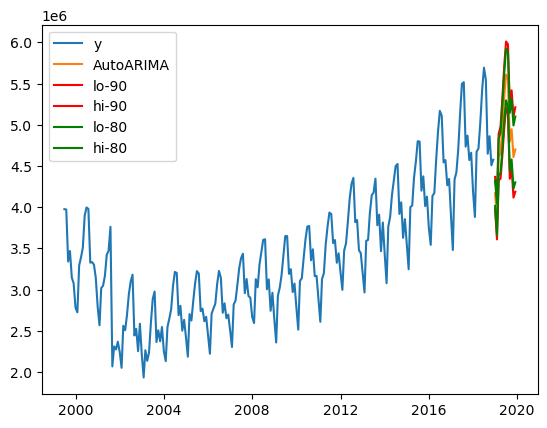

In [80]:
plt.plot(train_pre_covid['ds'], train_pre_covid['y'], label='y')
plt.plot(forecast['ds'], forecast['AutoARIMA'], label='AutoARIMA')
plt.plot(forecast['ds'], forecast[f'AutoARIMA-lo-90'], color = 'r', label='lo-90')
plt.plot(forecast['ds'], forecast[f'AutoARIMA-hi-90'], color = 'r', label='hi-90')
plt.plot(forecast['ds'], forecast[f'AutoARIMA-lo-80'], color = 'g', label='lo-80')
plt.plot(forecast['ds'], forecast[f'AutoARIMA-hi-80'], color = 'g', label='hi-80')
plt.legend()

## Post Covid

In [66]:
from statsforecast.models import HistoricAverage, SeasonalNaive, AutoARIMA, AutoETS

models = [
    AutoETS(season_length=1),
]

sf = StatsForecast(
    models=models,
    freq='MS',
    df=train_post_covid
)

# Perform Cross Validation
start = time.time()
sf.fit()
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

Finished Cross Validation, took about 0.01 seconds


In [70]:
# Perform Cross Validation
start = time.time()
forecast = sf.forecast(h=12)
end = time.time()
print(f"Finished Cross Validation, took about {end-start:.2f} seconds")

Finished Cross Validation, took about 0.01 seconds


c:\Users\USER\anaconda3\envs\forecasting-tools\lib\site-packages\numpy\core\numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


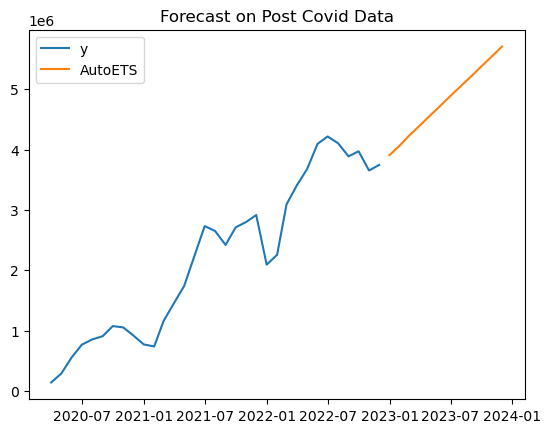

In [72]:
plt.plot(train_post_covid['ds'], train_post_covid['y'], label='y')
for model in models:
    plt.plot(forecast['ds'], forecast[model.__class__.__name__], label=model.__class__.__name__)
plt.title("Forecast on Post Covid Data")
plt.legend()
plt.show()